<a href="https://colab.research.google.com/github/ahhCrap/Deepfake_Review_Detection/blob/master/AttnLM_online.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attentive Language Model

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

## Imports

In [0]:
import torch as t
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F

from torch.nn.modules.loss import NLLLoss
from torch.nn.utils.rnn import pad_sequence

In [0]:
import numpy as np
import pandas as pd
import scipy.special as sps
import matplotlib.pyplot as plt

In [0]:
import json
import pickle

from tqdm import tqdm
from random import random
from collections import defaultdict

In [0]:
import nltk
import nltk.translate.bleu_score as bleu
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Configuration

In [0]:
device = t.device("cuda:0" if (t.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
VOCAB_SIZE = 1024
BATCH_SIZE = 64

Q_DIM = K_DIM = V_DIM = 32
HID_DIM = 1024
EMB_DIM = 256

MAX_LEN = 14
MAX_SEQ = MAX_LEN + 1

OPT = opt.Adam 
HEADS = 3
N_LAY = 8
LR = 1e-4

## Utils

### Save

In [0]:
def load(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [0]:
def save(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file,outfile)
    outfile.close()

In [0]:
def record_checkpoint(e, model, losses, version):
    t.save({
        'epoch': e,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': model.opt.state_dict(),
        'losses': losses,
        }, model_path + 'TRANS' + str(version) + '_checkpoint_' + str(e))

### Text

In [0]:
def tokenize_online(file_path):
    tokenized_sentences = []
    with open(file_path, 'r') as f:
        for line in f:
            tokenized_sentences += [word_tokenize(line.lower())]
    return tokenized_sentences

In [0]:
def ids_from_sent(sent):
    return [vocab.word2index[tok] for tok in sent]

In [0]:
def tens_from_text(text):
    return ([t.tensor([SOS] + ids_from_sent(s), device=device) for s in text], 
            [t.tensor(ids_from_sent(s) + [EOS], device=device) for s in text])

In [0]:
tok2read = {'PAD': ' ', 'UNK': 'unk', 'SOS': '>>', 'EOS': '<<'}

In [0]:
def raw2readable(sentence):
    for i, w in enumerate(sentence):
        if w in tok2read:
            sentence[i] = tok2read[w]
    return sentence

In [0]:
tok2adv = {'PAD': '', 'UNK': 'unk', 'SOS': '', 'EOS': ''}

In [0]:
def raw2adversarial(sentence):
    for i, w in enumerate(sentence):
        if w in tok2adv:
            sentence[i] = tok2adv[w]
    return sentence

In [0]:
def compute_size(dataset):
    dataset_size = 0
    with open(dataset, 'r') as f:
        for line in f:
            dataset_size += 1
    return dataset_size

In [0]:
def prep_sentences(sentences):
    assert isinstance(sentences[0], list), "'sentences' is not list of list"
    return [['SOS']+sent+['EOS']+['PAD']*(MAX_SEQ-len(sent)-2) for sent in sentences]

### Math

In [0]:
def cal_angle(position, hid_idx, emb_dim):
    return position / np.power(10000, 2 * (hid_idx // 2) / emb_dim)

def get_posi_angle_vec(position, emb_dim):
    return [cal_angle(position, hid_j, emb_dim) for hid_j in range(emb_dim)]

def sinusoid_encoding_table(n_position, emb_dim=EMB_DIM):
    sinusoid_table = np.array(
        [get_posi_angle_vec(pos_i, emb_dim) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return t.tensor(sinusoid_table, dtype=t.float, device=device)

In [0]:
def pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k).to(device)  # batch_size x len_q x len_k

In [0]:
def seq_mask(batch_size, seq_len):
    attn_shape = (batch_size, seq_len, seq_len)
    subsequent_mask = t.triu(t.ones(attn_shape, dtype=t.bool, device=device), diagonal=1)
    return subsequent_mask # subsequent_mask: [batch_size, seq, seq]

In [0]:
def pad_like(tensor, t_like):
    old_shape = tensor.shape
    new_shape = t_like.shape
    assert len(old_shape) == len(new_shape)
    
    diffs = []
    for i in range(len(old_shape)):
        diffs += [new_shape[i] - old_shape[i]]
    pads = []
    for d in diffs:
        half = d//2
        rest = d - half
        pads.extend([half, rest])
    
    return F.pad(tensor, pads[::-1], mode='constant', value=PAD)

In [0]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def truncated_permutation(n, max_n):
    assert n < max_n

    perm = set()
    while len(perm) < n:
        random_samples = np.random.randint(low=0, high=max_n-1, size=(n-len(perm)))
        perm.update(random_samples.tolist())
    return list(perm)

## Dataset

### Vocabulary

In [0]:
PAD = 0
UNK = 1
SOS = 2
EOS = 3

class Vocab:
    def __init__(self):
        self.word2count = {}
        self.word2index = {'PAD': PAD, 'UNK': UNK, "SOS": SOS, "EOS": EOS}
        self.index2word = {PAD: 'PAD', UNK: 'UNK', SOS: "SOS", EOS: "EOS"}
        self.n_words = 4 
        
    def add_text(self, text):
        for sent in tqdm(text): # assuming the text is a list of sentences
            for tok in sent:
                self.add_word(tok)

    def add_word(self, word):
        try:
            self.word2count[word] += 1
        except KeyError:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1

    def trim(self, n_tokens):
        n_tokens -= 4 # Since we have 4 special characters
        
        words = list(self.word2count.keys())
        counts = list(self.word2count.values())
        counts, words = zip(*sorted(zip(counts, words))) # order the words by their usage
        
        # ============= Re-create 'word2index' and 'word2count' ================
        temp_word2index = {'PAD': PAD, 'UNK': UNK, "SOS": SOS, "EOS": EOS}
        temp_word2count = {PAD: 'PAD', UNK: 'UNK', SOS: "SOS", EOS: "EOS"}
        temp_n_words = 4         
        
        for w in list(words)[-n_tokens:]:
            temp_word2index[w] = temp_n_words
            temp_word2count[w] = self.word2count[w]
            temp_n_words += 1
            
        self.word2index = defaultdict(lambda: UNK, temp_word2index)
        self.word2count = defaultdict(lambda: 0, temp_word2count)
        self.n_words = temp_n_words
            
        # ====================== Re-create 'index2word' ========================
        self.index2word = {}    
        for w, i in self.word2index.items():
            self.index2word[i] = w

### Batcher

In [0]:
# creates the batches and pads sequences
class Batcher:
    def __init__(self, pad=PAD):
        self.pad = pad

    def get_batches(self, tensors, batch_size):
        n = len(tensors)
        drop = n % batch_size

        dropped = tensors[-drop:] if drop != 0 else []

        batches = []
        for i in range(n // batch_size - 1):
           batches.append(tensors[i * batch_size:(i + 1) * batch_size]) 
        
        return batches, dropped
    
    def pad_batches(self, batches, batch_first=True):
        swap = (1, 0) if batch_first else (0, 1)
        return [pad_sequence(batch, padding_value=self.pad).permute(swap).to(device) for batch in batches]

    def insta_batch(self, sents):
        assert isinstance(sents[0], list), "'sents' is not list of list"

        temp_sents = sents + [['dummy'] * MAX_LEN]
        (inp_tens, tar_tens) = tens_from_text(temp_sents)
        return (pad_sequence(inp_tens, padding_value=self.pad)[:, :-1].permute(1, 0).to(device),
                pad_sequence(tar_tens, padding_value=self.pad)[:, :-1].permute(1, 0).to(device))

## Architecture

### Attention

In [0]:
MASK = float('-inf')

In [0]:
class ScaledAttn(nn.Module):
    def __init__(self):
        super(ScaledAttn, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        batch_size, n_heads, seq_len, dim = Q.shape

        scores = t.matmul(Q, K.transpose(-1, -2)) / np.sqrt(dim) # scores: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, MASK) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = t.matmul(attn, V)
        return context, attn

In [0]:
# Modified for self-attention only
class MHA(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, dim=Q_DIM, n_heads=HEADS):
        super(MHA, self).__init__()
        
        self.dim = dim # dimension of querys, keys and values
        self.emb_dim = emb_dim
        self.n_heads = n_heads
        
        self.W_Q = nn.Linear(emb_dim, n_heads * dim) 
        self.W_K = nn.Linear(emb_dim, n_heads * dim) 
        self.W_V = nn.Linear(emb_dim, n_heads * dim) 
        
        self.projection = nn.Linear(n_heads * dim, emb_dim)
        self.lay_norm = nn.LayerNorm(emb_dim)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x seq_len x dim], k: [batch_size x seq_len x dim], v: [batch_size x seq_len x dim]
        residual = Q
        batch_size, seq_len, emb_dim = Q.shape

        # (B, S, E) -proj-> (B, S, H x D) -split-> (B, S, H, D) -trans-> (B, H, S, D)
        q_s = self.W_Q(Q).view(batch_size, seq_len, self.n_heads, self.dim).transpose(1, 2)  # q_s: [batch_size x n_heads x seq_len x dim]
        k_s = self.W_K(K).view(batch_size, seq_len, self.n_heads, self.dim).transpose(1, 2)  # k_s: [batch_size x n_heads x seq_len x dim]
        v_s = self.W_V(V).view(batch_size, seq_len, self.n_heads, self.dim).transpose(1, 2)  # v_s: [batch_size x n_heads x seq_len x dim]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x seq_len x seq_len]

        # context: [batch_size x n_heads x seq_len x dim], attn: [batch_size x n_heads x seq_len x seq_len]
        context, attn = ScaledAttn()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.n_heads * self.dim) # context: [batch_size x seq_len x n_heads * dim]
        output = self.projection(context)
        return self.lay_norm(output + residual), attn # output: [batch_size x seq_len x emb_dim]

### Decoder

In [0]:
class PWFF(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM):
        super(PWFF, self).__init__()
        self.conv1 = nn.Conv1d(emb_dim, hid_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(hid_dim, emb_dim, kernel_size=1)
        self.lay_norm = nn.LayerNorm(emb_dim)

    def forward(self, inputs):
        output = self.conv1(inputs.transpose(1, 2))
        output = t.relu(output)
        output = self.conv2(output).transpose(1, 2)
        output = self.lay_norm(output + inputs)
        return t.relu(output)

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, dim=Q_DIM, n_heads=HEADS):
        super(DecoderLayer, self).__init__()
        self.mha = MHA(emb_dim, dim, n_heads)
        self.pwff = PWFF(emb_dim, hid_dim)

    def forward(self, inputs, mask):
        outputs, self_attn = self.mha(inputs, inputs, inputs, mask)
        outputs = self.pwff(outputs)
        return outputs, self_attn

In [0]:
class Decoder(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, dim=Q_DIM, 
                 n_heads=HEADS, n_layers=N_LAY, vocab_size=VOCAB_SIZE):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_encoding_table(MAX_LEN+1+1, emb_dim), freeze=True)
        self.layers = nn.ModuleList([DecoderLayer(emb_dim, hid_dim, dim, n_heads)] * n_layers)

    def forward(self, inputs): # dec_inputs : [batch_size x target_len]
        batch_size, seq_len = inputs.shape

        target_emb = self.tgt_emb(inputs) 
        target_emb += self.pos_emb(t.tensor(
            [[seq_len]+[*range(1, seq_len)]] * batch_size, dtype=t.long).to(device))

        padding = pad_mask(inputs, inputs)
        subseq = seq_mask(batch_size, seq_len)
        attn_mask = t.gt((padding + subseq), 0)

        attns = []
        for layer in self.layers:
            dec_outputs, attn = layer(target_emb, attn_mask)
            attns += [attn]
        
        return dec_outputs, attns

In [0]:
class HeadedDecoder(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, dim=Q_DIM, 
                 n_heads=HEADS, n_layers=N_LAY, vocab_size=VOCAB_SIZE):
        super(HeadedDecoder, self).__init__()
        
        self.decoder = Decoder(emb_dim, hid_dim, dim, n_heads, n_layers, vocab_size)
        self.projection = nn.Linear(emb_dim, vocab_size, bias=False)

        self.opt = OPT(self.parameters(), LR)

    def forward(self, dec_inputs):
        dec_outputs, attns = self.decoder(dec_inputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        
        probs = F.log_softmax(dec_logits, dim=-1)
        return probs, attns

## Optimization

### Iteration

In [0]:
def train_iter(model, input, target):
    model.train()
    model.opt.zero_grad()
    
    batch_size, seq_len = input.shape

    probs, _ = model(input)

    loss = NLLLoss(reduction='mean')(
        probs.reshape(batch_size * seq_len, VOCAB_SIZE), 
        target.reshape(batch_size * seq_len))
        
    loss.backward()
    model.opt.step()
    return loss.item()

### Epoch

In [0]:
N_DOTS = 10

In [0]:
def epoch(file_path, model, batch_size=BATCH_SIZE):
    d_size = compute_size(file_path)
    with open(file_path, 'r') as f:
        i = 1
        batch = []
        batch_losses = []
        for line in f:
            batch += [word_tokenize(json.loads(line)['review'].lower())]

            if len(batch) == batch_size:
                inp_batch, tar_batch = batcher.insta_batch(batch)
                batch_losses += [train_iter(model, inp_batch, tar_batch)]
                batch = []
            # ----------------------- UPDATING PROGRESS ------------------------
            if len(batch_losses) > i * ((d_size / batch_size) // N_DOTS):
                print('.', sep='', end='') 
                i += 1
            # ------------------------------------------------------------------ 
    print(' |', sep=' ', end=' ')
    return sum(batch_losses) / len(batch_losses)

### Training

In [0]:
def train(file_path, model, epochs, batch_size=BATCH_SIZE):
    d_size = compute_size(file_path)
    losses = []
    for i in range(e, epochs+e):
        print('Epoch:', '{:3d}'.format(i), '|', sep=' ', end=' ')
        losses += [epoch(file_path, model, batch_size)]
            
        print('Loss:', '{:7.6f}'.format(losses[-1]), '|')
    return losses, epochs+e

## Evaluation

In [0]:
def tensors2sentences(tensors, vocab, batched=True, at=2):
    if not batched: tensors = tensors.unsqueeze(0)
    sentences = []
    for i in range(tensors.size(0)):
        sentences += [[vocab.index2word[n.item()] for n in tensors[i, :]]]
        if i > at: break
    return sentences

In [0]:
def greedy_decoder(model, start_symbol=SOS):
    model.eval()

    dec_input = t.zeros(1, MAX_LEN + 1, dtype=t.long).to(device) # PAD = 0
    next_symbol = start_symbol

    for i in range(MAX_SEQ):
        dec_input[0][i] = next_symbol

        dec_outputs, attn = model.decoder(dec_input)
        dec_outputs = model.projection(dec_outputs)

        probs, ids = dec_outputs.squeeze().max(dim=-1, keepdim=False)
        next_symbol = ids.data[i].item()
    
    return ids, attn

In [0]:
def topk_decoder(model, k=10, start_symbol=SOS):
    model.eval()

    dec_input = t.zeros(1, MAX_LEN + 1, dtype=t.long).to(device) # PAD = 0
    next_symbol = start_symbol
    dec_input[0][0] = next_symbol

    for i in range(MAX_SEQ):
        new_pool = int(k * (1 - i/MAX_SEQ) + 1)

        probs, attn = model(dec_input)
        top_vals, top_ids = t.topk(probs.squeeze(), k=new_pool, dim=-1)
        top_ids = top_ids[i, :]

        pick = int(random() * new_pool)
        next_symbol = top_ids.data[pick].item()
        dec_input[0][i] = next_symbol

    return dec_input.squeeze(), attn

In [0]:
def temperature_decoder(model, temp=5, start_symbol=SOS):
    model.eval()

    dec_input = t.zeros(1, MAX_LEN + 1, dtype=t.long).to(device) # PAD = 0
    next_symbol = start_symbol
    dec_input[0][0] = next_symbol

    new_temp = temp
    for i in range(MAX_SEQ):
        probs, attn = model(dec_input)
        temperature_probs = F.softmax(probs / new_temp, dim=-1)[0, i, :].cpu().data.numpy()
        next_symbol = np.random.choice(len(temperature_probs), size=(1), p=temperature_probs)
        dec_input[0][i] = t.tensor(next_symbol, dtype=t.long)
        
        # Exponental decay
        #new_temp /= 2
        # Linear decay
        new_temp = temp * (1 - (i+2)/MAX_SEQ) + 1e-6

    return dec_input.squeeze(), attn

# Main

## Data Structuring

In [0]:
dir_path = '/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/'
model_path = '/content/drive/My Drive/POLIMI/Thesis/Data/Models/'

In [0]:
train_name = 'test.jsonl'
file_path = dir_path + train_name
file_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/test.jsonl'

In [0]:
vocab = Vocab()
vocab.add_text(tokenize_online(file_path))
vocab.trim(VOCAB_SIZE)

100%|██████████| 95439/95439 [00:00<00:00, 124851.59it/s]


In [0]:
batcher = Batcher()

In [0]:
compute_size(file_path)

95439

## Training

In [0]:
model = HeadedDecoder(EMB_DIM, HID_DIM, Q_DIM, HEADS, N_LAY, VOCAB_SIZE).to(device)
count_params(model)

1149728

In [0]:
RESTART = True

In [0]:
if RESTART:
    e = 0
    losses = []
else:
    VERSION = 2
    e = 16

    checkpoint = t.load(model_path + 'TRANS' +  str(VERSION) + '_checkpoint_' + str(e), map_location=t.device(device))
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.opt.load_state_dict(checkpoint['optimizer_state_dict'])

    e = checkpoint['epoch']

    losses = checkpoint['losses']
    model.train()

In [0]:
VERSION = 2

In [0]:
EPOCHS = 16
TIMES = 1
START = 0
MID = False

In [0]:
for j in range(START, START + TIMES):

    # -------------------------- PARAMETERS SETTING ----------------------------
    lr = LR
    epcs =  EPOCHS 
    batch_size = BATCH_SIZE * (2**j)
    if MID is True: 
        model.opt = OPT(model.parameters(), lr, betas=[0.9, 0.999])
    print('Batch Size:', batch_size, '|', 'Learning Rate:', lr)
    # --------------------------------------------------------------------------

    loss, e = train(file_path, model, epcs, batch_size)
    losses += loss

    record_checkpoint(e, model, losses, VERSION)

Batch Size: 64 | Learning Rate: 0.0001
Epoch:   0 | .......... | Loss: 2.241120 |
Epoch:   1 | .......... | Loss: 1.834055 |
Epoch:   2 | .......... | Loss: 1.760567 |
Epoch:   3 | .......... | Loss: 1.719383 |
Epoch:   4 | .......... | Loss: 1.690709 |
Epoch:   5 | .......... | Loss: 1.668445 |
Epoch:   6 | .......... | Loss: 1.650018 |
Epoch:   7 | .......... | Loss: 1.634321 |
Epoch:   8 | .......... | Loss: 1.620717 |
Epoch:   9 | .......... | Loss: 1.608665 |
Epoch:  10 | .......... | Loss: 1.597857 |
Epoch:  11 | .......... | Loss: 1.587986 |
Epoch:  12 | .......... | Loss: 1.578884 |
Epoch:  13 | .......... | Loss: 1.570377 |
Epoch:  14 | .......... | Loss: 1.562415 |
Epoch:  15 | .......... | Loss: 1.554859 |


## Evaluation

In [0]:
TAKE = True

In [0]:
if TAKE:
    EPOCH_COMPARE = 16
    VERSION_COMPARE = 33

    checkpoint_compare = t.load(
        model_path + str(VERSION_COMPARE) + '_checkpoint_' + str(EPOCH_COMPARE), 
        map_location=t.device(device))
    
    nll_losses_compare = checkpoint_compare['nll_losses']
    # kld_losses_compare = checkpoint_compare['kld_losses']

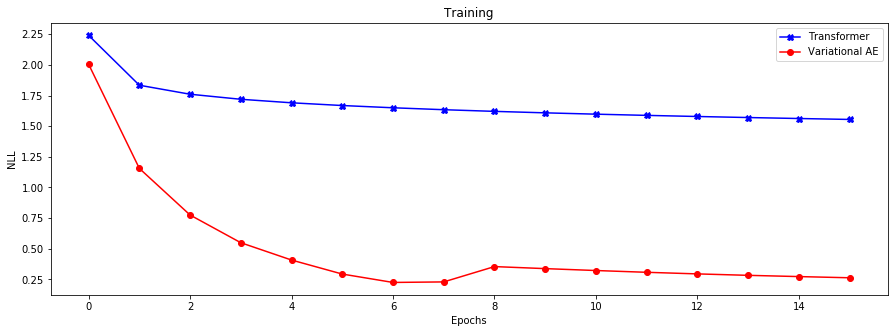

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(losses, 'bX-' ,label='Transformer')
plt.plot(nll_losses_compare, 'ro-' ,label='Variational AE')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [0]:
dec_input, attn = greedy_decoder(model, SOS)
'SOS '+' '.join(vocab.index2word[inp.item()] for inp in dec_input)

'SOS great product EOS EOS EOS EOS EOS EOS EOS EOS EOS . EOS EOS EOS'

In [0]:
dec_input, attn = topk_decoder(model, k=10, start_symbol=SOS)
'SOS '+' '.join(vocab.index2word[inp.item()] for inp in dec_input)

'SOS good UNK as PAD timely PAD UNK , PAD PAD PAD PAD UNK EOS PAD'

In [0]:
dec_input, attn = temperature_decoder(model, temp=4, start_symbol=SOS)
'SOS '+' '.join(vocab.index2word[inp.item()] for inp in dec_input)

'SOS it looking PAD fast PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

## Adversarial Dataset Generation

In [0]:
ADV_SIZE = 1024
SAFETY = 50
TEMP = 4
K = 10

In [0]:
adv_dataset = set()
for i in tqdm(range(ADV_SIZE + SAFETY)):
    out, _ = topk_decoder(model, k=K, start_symbol=SOS)
    sentence = ['SOS'] + [vocab.index2word[inp.item()] for inp in out]
    adv_dataset.add(' '.join(raw2adversarial(sentence))[1:])

adv_dataset = sorted(list(adv_dataset))[:ADV_SIZE]

100%|██████████| 1074/1074 [02:50<00:00,  6.15it/s]


In [0]:
GENERATE_IT = True
if GENERATE_IT:
    adv_path = dir_path + 'adversarial_k' + str(K) + '.jsonl'
    with open(adv_path, 'w') as f:
        i = 0
        for r in tqdm(adv_dataset):
            json.dump({'id': i, 'review': r}, f)
            f.write('\n')
            i += 1

100%|██████████| 1024/1024 [00:00<00:00, 58762.72it/s]


In [0]:
second_adv_dataset = set()
for i in tqdm(range(ADV_SIZE + SAFETY)):
    out, _ = temperature_decoder(model, temp=TEMP, start_symbol=SOS)
    sentence = ['SOS'] + [vocab.index2word[inp.item()] for inp in out]
    second_adv_dataset.add(' '.join(raw2adversarial(sentence))[1:])

second_adv_dataset = sorted(list(second_adv_dataset))[:ADV_SIZE]

100%|██████████| 1074/1074 [02:53<00:00,  6.26it/s]


1074

In [0]:
GENERATE_IT = True
if GENERATE_IT:
    adv_path = dir_path + 'adversarial_temp' + str(TEMP) + '.jsonl'
    with open(adv_path, 'w') as f:
        i = 0
        for r in tqdm(second_adv_dataset):
            json.dump({'id': i, 'review': r}, f)
            f.write('\n')
            i += 1

100%|██████████| 1024/1024 [00:00<00:00, 59647.35it/s]
